In [1]:
import numpy as np
import pandas as pd
from quetzal.model import stepmodel
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\marlin.arnz\AppData\Local\Continuum\miniconda3\envs\quetzal\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none func

# Validation dashboard for inter-cellular trips
Validate the results with VP2030 data

In [2]:
input_path = '../input_static/'
output_path = '../output/'
model_path = '../model/'

## Prepare input data for validation

### VP2030

In [3]:
vp2017 = pd.read_csv(input_path + 'vp2017_validation_normalised.csv')
# Restrict to inter-cell traffic and cells of the model
vp2017 = vp2017.loc[(vp2017['origin']!=vp2017['destination']) &
                    (vp2017['origin'].notna()) &
                    (vp2017['destination'].notna())]
vp2017.set_index(['origin', 'destination'], drop=True, inplace=True)
vp2017.shape

(216869, 25)

In [4]:
segment_dict = {'Fz1':'commuting', 'Fz2':'education', 'Fz3':'shopping/medical', 'Fz4':'business', 'Fz6':'private'}
mode_dict_vp = {'Bahn': 'rail', 'MIV': 'car', 'Luft': 'air', 'OESPV': 'bus', 'non': 'walk'}

In [5]:
# Get the columns right
vp2017.columns = pd.MultiIndex.from_tuples(
    [(mode_dict_vp[col.split('_')[0]], col.split('_')[-1])
     for col in vp2017.columns],
    names=['mode', 'segment'])

In [6]:
vp2017.iloc[0:0]

Empty DataFrame
Columns: [(rail, Fz1), (rail, Fz2), (rail, Fz3), (rail, Fz4), (rail, Fz6), (car, Fz1), (car, Fz2), (car, Fz3), (car, Fz4), (car, Fz6), (air, Fz1), (air, Fz2), (air, Fz3), (air, Fz4), (air, Fz6), (bus, Fz1), (bus, Fz2), (bus, Fz3), (bus, Fz4), (bus, Fz6), (walk, Fz1), (walk, Fz2), (walk, Fz3), (walk, Fz4), (walk, Fz6)]
Index: []

[0 rows x 25 columns]

In [7]:
# Prevent small values from being dropped
vp2017 = vp2017 * 1000

### MiD2017

In [13]:
# Load calibration dataset
mid2017 = pd.read_csv(input_path + 'mid2017_validation_normalised.csv')
mid2017.set_index('mode_model', drop=True, inplace=True)
mid2017.shape

(7, 5)

In [14]:
# Merge rail modes and bus and coach
mode_dict_mid = {1: 'rail', 2: 'rail',
                 3: 'bus', 4: 'bus', 5: 'air', 6: 'car', 7: 'walk'}
mid2017['mode_agg'] = [mode_dict_mid[i] for i in mid2017.index]

### Model

In [15]:
# We don't need the assignment, just the mode choice
sm = stepmodel.read_json(model_path + 'de_logit')

In [17]:
sm.probabilities.loc[sm.probabilities.isna().any(axis=1)]

,origin,destination,segment,root,walk,car,air,pt,bus,coach,rail_short_distance,rail_long_distance
index,,,,,,,,,,,,


In [19]:
# Get probabilities in a tidy format
probs = sm.probabilities.set_index(['origin', 'destination', 'segment'])[
        ['walk', 'car', 'air', 'bus', 'coach', 'rail_short_distance', 'rail_long_distance']
    ].stack().rename('probability')
probs.index.set_names('route_type', level=3, inplace=True)

In [23]:
# Merge rail and public road
probs = probs.reset_index().replace(
    {'rail_short_distance': 'rail', 'rail_long_distance': 'rail', 'coach': 'bus'}
).groupby(['origin', 'destination', 'segment', 'route_type']
         ).agg({'probability': 'sum'})

In [27]:
# Merge probabilities and volumes
od = probs.unstack('route_type').merge(vp2017.stack('segment').sum(axis=1).rename('volumes'),
                                       how='right', right_index=True, left_index=True)

In [36]:
str(list(od.loc[od.isna().any(axis=1)].index.droplevel(2).unique()))

"[('DE139', 'DE803'), ('DE215', 'DE947'), ('DE803', 'DE139'), ('DE80J_2', 'DE139'), ('DE80K_1', 'DE139'), ('DE80L_1', 'DE138'), ('DE80L_1', 'DE139'), ('DE80L_1', 'DE13A'), ('DE80L_2', 'DE12C'), ('DE80L_2', 'DE131'), ('DE80L_2', 'DE133'), ('DE80L_2', 'DE134'), ('DE80L_2', 'DE135'), ('DE80L_2', 'DE136'), ('DE80L_2', 'DE137'), ('DE80L_2', 'DE138'), ('DE80L_2', 'DE139'), ('DE80L_2', 'DE13A'), ('DE80L_2', 'DE143'), ('DE80L_2', 'DE147'), ('DE80L_2', 'DE149'), ('DE80L_2', 'DE215'), ('DE80L_2', 'DE27A'), ('DE80L_2', 'DE27E'), ('DE80N_1', 'DE131'), ('DE80N_1', 'DE133'), ('DE80N_1', 'DE138'), ('DE80N_1', 'DE139'), ('DE80N_1', 'DE13A'), ('DE80N_2', 'DE139'), ('DE80N_3', 'DE131'), ('DE80N_3', 'DE133'), ('DE80N_3', 'DE134'), ('DE80N_3', 'DE136'), ('DE80N_3', 'DE137'), ('DE80N_3', 'DE138'), ('DE80N_3', 'DE139'), ('DE80N_3', 'DE13A'), ('DE80N_3', 'DE147'), ('DE80N_3', 'DEC02'), ('DEF07_1', 'DE215'), ('DEF07_2', 'DE139'), ('DEF07_2', 'DE13A'), ('DEF07_2', 'DE215'), ('DEF07_2', 'DE21D'), ('DEF07_2', 'D

In [37]:
# Multiply probabilities with volumes
modes = ['air', 'bus', 'car', 'rail', 'walk']
for m in modes:
    od[m] = od[('probability', m)] * od['volumes']
od = od[modes]

In [38]:
od.loc[(od<0).any(axis=1)]

,,,air,bus,car,rail,walk
origin,destination,segment,,,,,


In [40]:
# OD pairs where there is no route in the model
od.loc[od.isna().any(axis=1)]

air  bus  car  rail  walk
origin destination segment                           
DE139  DE803       Fz1      NaN  NaN  NaN   NaN   NaN
                   Fz2      NaN  NaN  NaN   NaN   NaN
                   Fz3      NaN  NaN  NaN   NaN   NaN
                   Fz4      NaN  NaN  NaN   NaN   NaN
                   Fz6      NaN  NaN  NaN   NaN   NaN
...                         ...  ...  ...   ...   ...
DE215  DEF08_2     Fz1      NaN  NaN  NaN   NaN   NaN
                   Fz2      NaN  NaN  NaN   NaN   NaN
                   Fz3      NaN  NaN  NaN   NaN   NaN
                   Fz4      NaN  NaN  NaN   NaN   NaN
                   Fz6      NaN  NaN  NaN   NaN   NaN

[530 rows x 5 columns]

In [41]:
print(len(od))
od = od.loc[od.notna().all(axis=1)]
print(len(od))

1084345
1083815


### Distances

In [42]:
# Load centroids to compute a distance matrix
import geopandas as gpd
z = stepmodel.read_json(model_path + 'de_zones')
centr = gpd.GeoDataFrame(z.zones).centroid

In [43]:
distances = pd.DataFrame(index=centr.index)
for i, g in centr.items():
    distances[i] = [g.distance(p) for p in list(centr)]

In [44]:
distances.shape

(467, 467)

## Plot averages

array([<AxesSubplot:ylabel='commuting'>, <AxesSubplot:ylabel='education'>,
       <AxesSubplot:ylabel='shopping/medical'>,
       <AxesSubplot:ylabel='business'>, <AxesSubplot:ylabel='private'>],
      dtype=object)

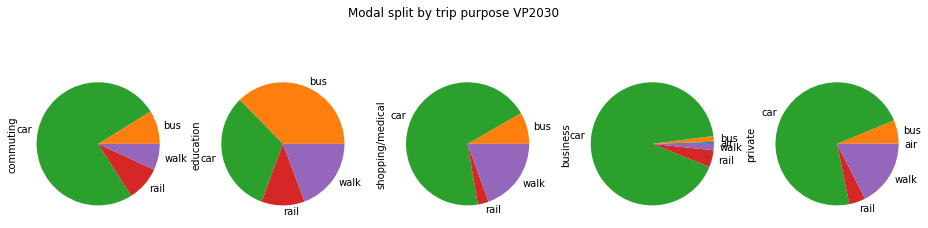

In [45]:
# VP2030
vp2017.T.sum(axis=1).unstack('segment').rename(columns=segment_dict).plot.pie(
    subplots=True, figsize=(16, 4), legend=False, title='Modal split by trip purpose VP2030')

array([<AxesSubplot:ylabel='1'>, <AxesSubplot:ylabel='2'>,
       <AxesSubplot:ylabel='3'>, <AxesSubplot:ylabel='4'>,
       <AxesSubplot:ylabel='6'>], dtype=object)

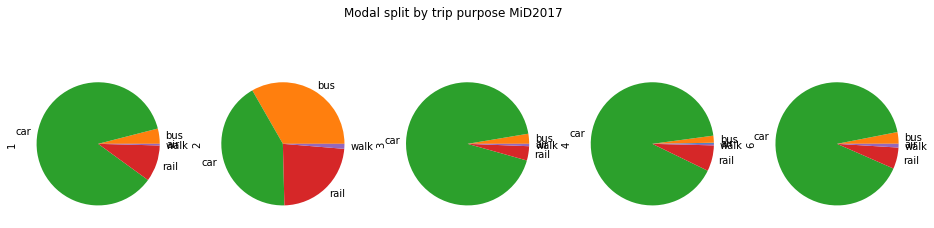

In [46]:
# MiD2017
mid2017.rename(
    columns={1:'commuting', 2:'education', 3:'shopping/medical', 4:'business', 6:'private'}
).groupby('mode_agg').sum().plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose MiD2017')

array([<AxesSubplot:ylabel='commuting'>, <AxesSubplot:ylabel='education'>,
       <AxesSubplot:ylabel='shopping/medical'>,
       <AxesSubplot:ylabel='business'>, <AxesSubplot:ylabel='private'>],
      dtype=object)

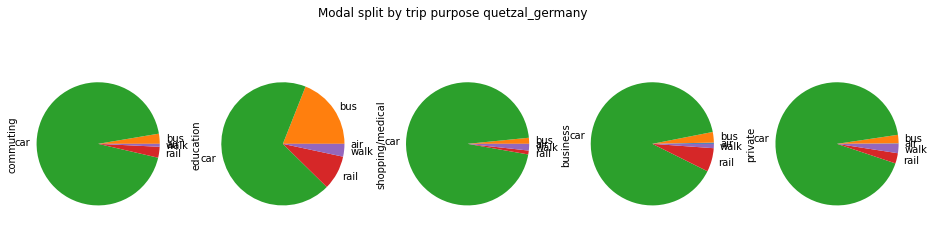

In [47]:
# Model results
od_norm = od.rename(index=segment_dict).unstack('segment').sum().T.unstack('segment')
od_norm = od_norm/(od_norm.max()-od_norm.min()) # Normalise by column
od_norm[['commuting', 'education', 'shopping/medical', 'business', 'private']].plot.pie(
    subplots=True, figsize=(16, 4), legend=False,
    title='Modal split by trip purpose quetzal_germany')

<AxesSubplot:ylabel='None'>

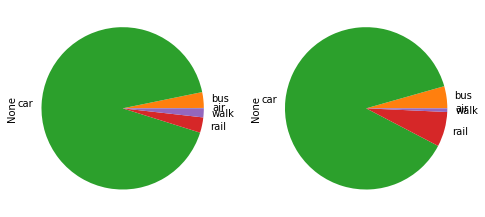

In [48]:
# Overall average compared to MiD2017
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
od.sum().plot.pie(ax=ax[0])
mid2017.groupby('mode_agg').sum().sum(axis=1).plot.pie(ax=ax[1])

In [49]:
# Average probabilities
sm.probabilities.groupby('segment').agg({'walk': 'mean', 'car': 'mean',
                                         'air': 'mean', 'bus': 'mean',
                                         'coach': 'mean', 'rail_short_distance': 'mean',
                                         'rail_long_distance': 'mean'})

,walk,car,air,bus,coach,rail_short_distance,rail_long_distance
segment,,,,,,,
Fz1,0.000046,0.963510,0.026502,0.002478,0.000680,0.001201,0.005584
Fz2,0.000185,0.779421,0.169015,0.018688,0.014554,0.004649,0.013487
Fz3,0.000100,0.943628,0.050606,0.002178,0.000168,0.000580,0.002739
Fz4,0.000095,0.851308,0.050425,0.001445,0.014386,0.023942,0.058399
Fz6,0.000174,0.926694,0.039360,0.002301,0.007456,0.005154,0.018860


In [50]:
# Average utilities
sm.utilities.groupby('segment').agg({'walk': 'mean', 'car': 'mean',
                                     'air': 'mean', 'bus': 'mean',
                                     'coach': 'mean', 'rail_short_distance': 'mean',
                                     'rail_long_distance': 'mean'})

,walk,car,air,bus,coach,rail_short_distance,rail_long_distance
segment,,,,,,,
Fz1,-2.892476,-4.953926,-13.832818,-2.893756,-13.722541,-16.017442,-13.735874
Fz2,-1.781624,-8.124105,-14.072681,-0.208498,-14.811053,-20.657967,-17.353410
Fz3,-2.188865,-5.550850,-13.718040,-3.226999,-15.851183,-17.883300,-15.448775
Fz4,-2.279405,0.120872,-2.157744,-2.047942,-2.940309,-2.716859,-2.359719
Fz6,-1.669033,-1.201664,-4.872198,-2.343016,-5.889996,-6.210506,-5.450110


### Distance-related

In [51]:
# VP2030 results by distance class (geometric distance between centroids)
dist_max = distances.max().max()
bins = [0,1,2,4,6,9]
t = vp2017.copy() * 100
t['dist'] = [distances.loc[i[0], i[1]] for i in t.index]
t['bins'] = pd.cut(t['dist'], bins=bins,
                   labels=['{}-{}'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)])
t.drop('dist', axis=1, inplace=True)
t2 = od.copy() * 100
t2['dist'] = [distances.loc[i[0], i[1]] for i in t2.index]
t2['bins'] = pd.cut(t2['dist'], bins=bins,
                    labels=['{}-{}'.format(bins[i], bins[i+1]) for i in range(len(bins)-1)])
t2.drop('dist', axis=1, inplace=True)

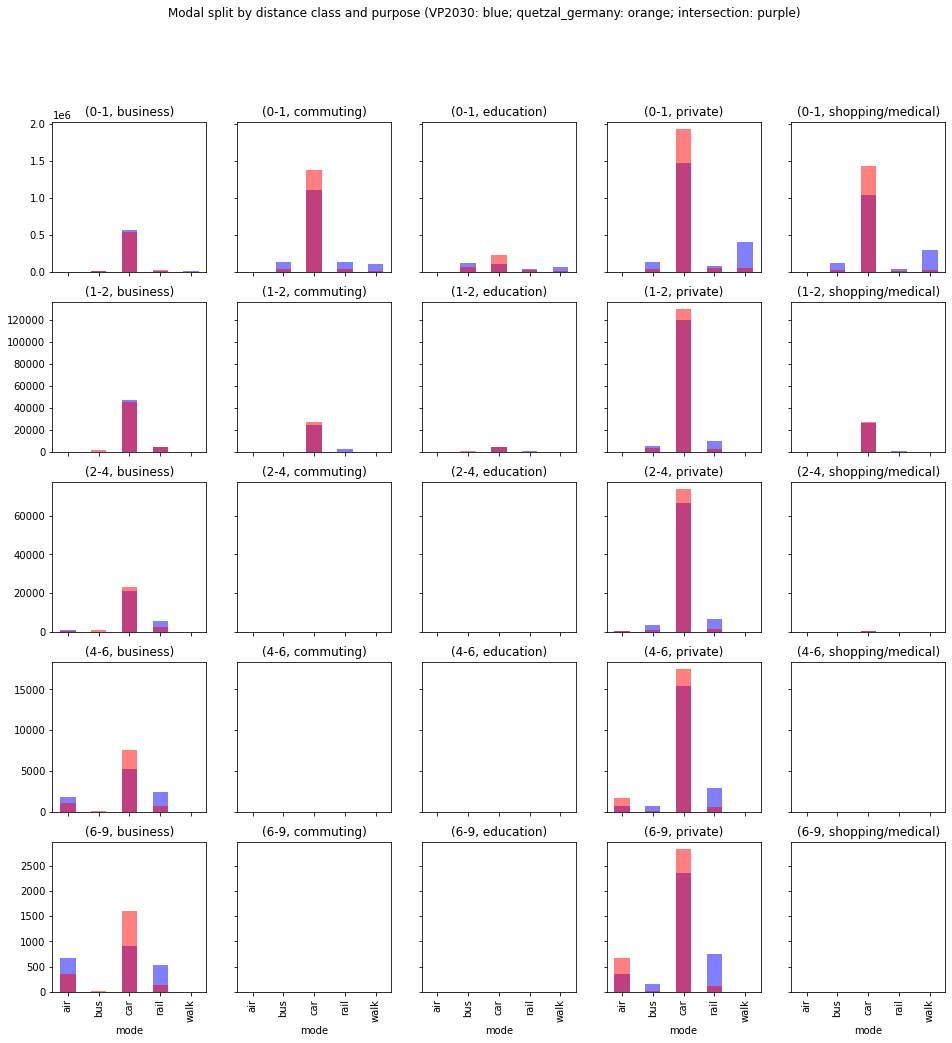

In [52]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(16,16), sharex='all', sharey='row')
t.groupby('bins').sum(axis=0).rename(columns=segment_dict).stack('segment').T.plot.bar(#.pie(
    ax=ax, subplots=True, legend=False, color='blue', alpha=0.5,
    title='Modal split by distance class and purpose (VP2030: blue; quetzal_germany: orange; intersection: purple)')
t2.unstack('segment').groupby(('bins', 'Fz1')).sum(axis=0).drop('bins', axis=1, level=0).rename(
    columns=segment_dict).T.unstack('segment').plot.bar(
    ax=ax, subplots=True, legend=False, color='red', alpha=0.5)
print(' ')

### Location-related

array([<AxesSubplot:ylabel='DE1'>, <AxesSubplot:ylabel='DE2'>,
       <AxesSubplot:ylabel='DE3'>, <AxesSubplot:ylabel='DE4'>,
       <AxesSubplot:ylabel='DE5'>, <AxesSubplot:ylabel='DE6'>,
       <AxesSubplot:ylabel='DE7'>, <AxesSubplot:ylabel='DE8'>,
       <AxesSubplot:ylabel='DE9'>, <AxesSubplot:ylabel='DEA'>,
       <AxesSubplot:ylabel='DEB'>, <AxesSubplot:ylabel='DEC'>,
       <AxesSubplot:ylabel='DED'>, <AxesSubplot:ylabel='DEE'>,
       <AxesSubplot:ylabel='DEF'>, <AxesSubplot:ylabel='DEG'>],
      dtype=object)

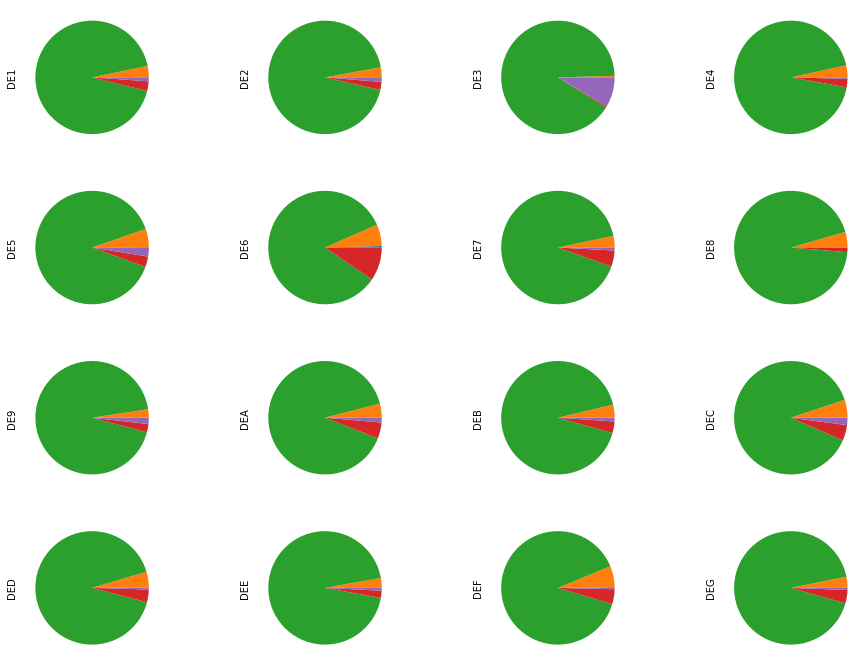

In [53]:
# Average by region (origin)
od['region'] = [s[:3] for s in list(od.reset_index()['origin'])]
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,12))
od.groupby('region').agg({col: 'sum' for col in modes}).T.plot.pie(
    subplots=True, labels=modes,
    startangle=0, counterclock=True,# colors=colors,
    legend=False, labeldistance=None, ax=ax)
#fig.legend()

array([<AxesSubplot:ylabel='DE1'>, <AxesSubplot:ylabel='DE2'>,
       <AxesSubplot:ylabel='DE3'>, <AxesSubplot:ylabel='DE4'>,
       <AxesSubplot:ylabel='DE5'>, <AxesSubplot:ylabel='DE6'>,
       <AxesSubplot:ylabel='DE7'>, <AxesSubplot:ylabel='DE8'>,
       <AxesSubplot:ylabel='DE9'>, <AxesSubplot:ylabel='DEA'>,
       <AxesSubplot:ylabel='DEB'>, <AxesSubplot:ylabel='DEC'>,
       <AxesSubplot:ylabel='DED'>, <AxesSubplot:ylabel='DEE'>,
       <AxesSubplot:ylabel='DEF'>, <AxesSubplot:ylabel='DEG'>],
      dtype=object)

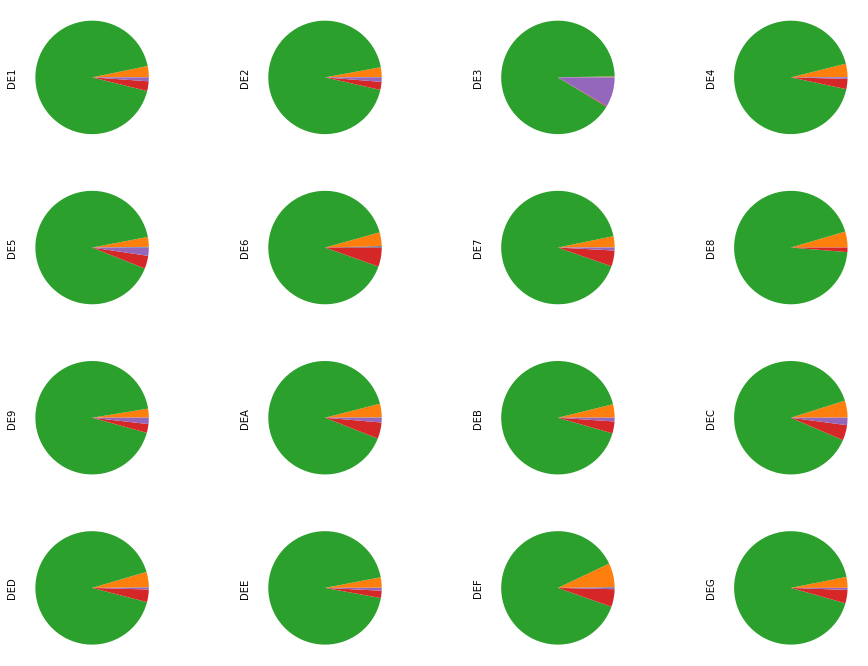

In [54]:
# Average by region (destination)
od['region'] = [s[:3] for s in list(od.reset_index()['destination'])]
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(16,12))
od.groupby('region').agg({col: 'sum' for col in modes}).T.plot.pie(
    subplots=True, labels=modes,
    startangle=0, counterclock=True,# colors=colors,
    legend=False, labeldistance=None, ax=ax)
#fig.legend()

In [55]:
od.drop('region', axis=1, inplace=True)

## Detailed comparison

Between model results and VP2030 results

In [56]:
# Compare model results and VP2030 in detail
# Merge each OD pair to compare volumes calculated
merged = vp2017.merge(od.unstack('segment').rename(columns={m:m+'_y' for m in od.columns}),
                      left_index=True, right_index=True).replace({np.nan: 0})

(0.0, 20.0)

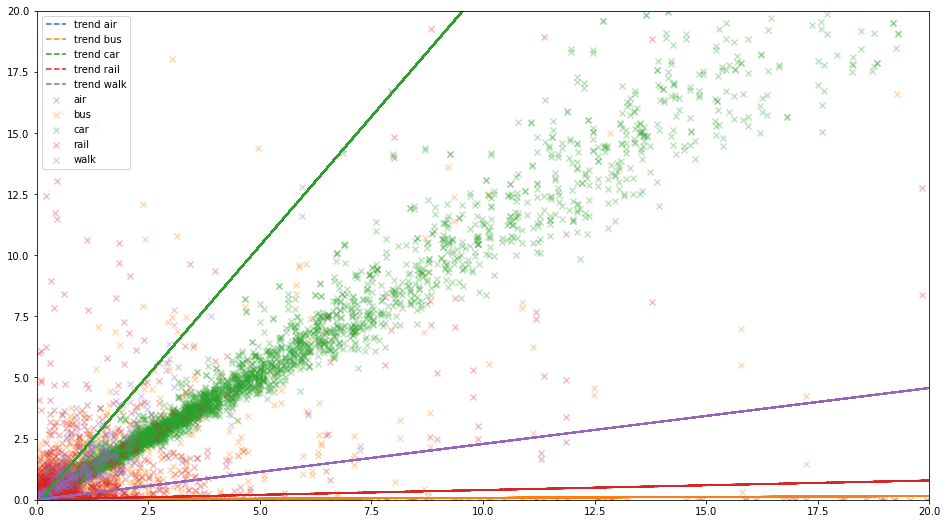

In [57]:
fig, ax = plt.subplots(figsize=(16,9))
for mode in modes:
    x = merged.loc[:, (mode, [k for k,_ in segment_dict.items()])].sum(axis=1)
    y = merged.loc[:, (mode+'_y', [k for k,_ in segment_dict.items()])].sum(axis=1)
    plt.scatter(x, y, marker='x', alpha=.3, label=mode)
    p = np.poly1d(np.polyfit(x, y, deg=1))
    plt.plot(x, p(x), linestyle='--', marker='', label='trend '+mode)
plt.legend()
plt.xlim(0, 20)
plt.ylim(0, 20)

In [58]:
# Zoom
fig, ax = plt.subplots(figsize=(16,9))
for mode in modes:
    x = merged.loc[:, (mode, [k for k,_ in segment_dict.items()])].sum(axis=1)
    y = merged.loc[:, (mode+'_y', [k for k,_ in segment_dict.items()])].sum(axis=1)
    plt.scatter(x, y, marker='x', alpha=.3, label=mode)
    p = np.poly1d(np.polyfit(x, y, deg=1))
    plt.plot(x, p(x), linestyle='--', marker='', label='trend '+mode)
plt.legend()
plt.xlim(0, 0.5)
plt.ylim(0, 0.5)

(0.0, 0.5)

OverflowError: Exceeded cell block limit (set 'agg.path.chunksize' rcparam)

<Figure size 1152x648 with 1 Axes>

In [59]:
# How good is the fit?
from sklearn.metrics import r2_score
for mode in modes:
    x = merged.loc[:, (mode, [k for k,_ in segment_dict.items()])].sum(axis=1)
    y = merged.loc[:, (mode+'_y', [k for k,_ in segment_dict.items()])].sum(axis=1)
    p = np.poly1d(np.polyfit(x, y, deg=1))
    print('R square for {}: {}'.format(mode, r2_score(y, p(x))))
# Overall fit
x = merged.loc[:, (modes, [k for k,_ in segment_dict.items()])].sum(axis=1)
y = merged.loc[:, ([m+'_y' for m in modes], [k for k,_ in segment_dict.items()])].sum(axis=1)
p = np.poly1d(np.polyfit(x, y, deg=1))
print('Overall R square: {}'.format(r2_score(y, p(x))))

R square for air: 0.6567498065003183
R square for bus: 0.005236456309823612
R square for car: 0.9030037638638864
R square for rail: 0.01797346974680425
R square for walk: 0.8156763357571544
Overall R square: 1.0


In [60]:
# Where are the connections with highest volumes?
from shapely import geometry
high_vol = od.unstack('segment').sum(axis=1).sort_values(0).tail(int(len(od.unstack('segment'))/100))
high_vol = high_vol.reset_index()
centr = gpd.GeoDataFrame(index=centr.index, geometry=list(centr))
high_vol = gpd.GeoDataFrame(high_vol, geometry=[geometry.LineString(
    [centr.loc[row['origin'], 'geometry'], centr.loc[row['destination'], 'geometry']])
                                                for _, row in high_vol.iterrows()])
high_vol.head(2)

,origin,destination,0,geometry
0,DE264_2,DE269,4.031590,"LINESTRING (9.07261 50.01933, 9.23470 49.75726)"
1,DED44,DED42,4.033344,"LINESTRING (12.23501 50.45686, 12.94497 50.60889)"


<AxesSubplot:>

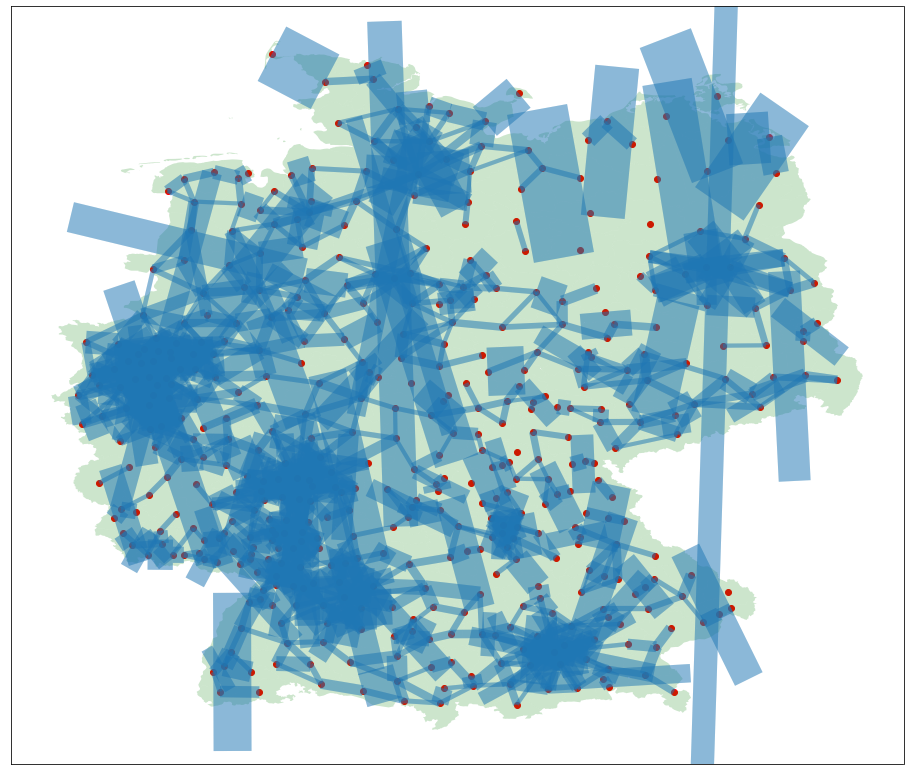

In [61]:
high_vol.plot(alpha=.3, linewidth=list(high_vol[0]),
              ax=z.plot('zones', alpha=.2, color='green',
                        ax=centr.plot(color='red', figsize=(16,16))))